In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from pylab import rcParams
import statsmodels.api as sm
import warnings
import itertools
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
prediction_data=pd.read_excel('/content/prediction_data.xlsx')
df=pd.read_excel('/content/train_data.xlsx')
df.head()

,일시,평균기온(℃),평균최고기온(℃),최고기온(℃),최고기온일자,평균최저기온(℃),최저기온(℃),최저기온일자,강수량,인구,아황산가스,일산화탄소,이산화질소,철새 합계
0,2014-01-01,-0.6,4.4,9.3,2014-01-01,-5.8,-10.8,2014-01-22,9.9,12709996,0.007,0.778,0.038,0
1,2014-02-26,2.1,7.4,16.0,2014-02-26,-2.3,-9.6,2014-02-04,16.5,12709996,0.006,0.733,0.035,0
2,2014-03-28,7.6,13.6,24.7,2014-03-28,2.3,-4.2,2014-03-10,10.9,12709996,0.006,0.622,0.039,0
3,2014-04-25,13.3,19.9,26.3,2014-04-25,7.9,1.4,2014-04-05,55.7,12709996,0.005,0.500,0.033,0
4,2014-05-31,18.2,25.2,33.2,2014-05-31,12.5,6.0,2014-05-06,64.4,12709996,0.005,0.456,0.030,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['평균기온(℃)','평균최고기온(℃)','최고기온(℃)','평균최저기온(℃)','최저기온(℃)','강수량','인구','아황산가스','일산화탄소','이산화질소','철새 합계'] ##수정 필요
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,평균기온(℃),평균최고기온(℃),최고기온(℃),평균최저기온(℃),최저기온(℃),강수량,인구,아황산가스,일산화탄소,이산화질소,철새 합계
0,0.093750,0.096273,0.019608,0.061728,0.157068,0.013743,0.0,1.0,1.000000,0.923077,0.000000
1,0.178125,0.189441,0.238562,0.169753,0.188482,0.023392,0.0,0.8,0.898876,0.807692,0.000000
2,0.350000,0.381988,0.522876,0.311728,0.329843,0.015205,0.0,0.8,0.649438,0.961538,0.000000
3,0.528125,0.577640,0.575163,0.484568,0.476440,0.080702,0.0,0.6,0.375281,0.730769,0.000000
4,0.681250,0.742236,0.800654,0.626543,0.596859,0.093421,0.0,0.6,0.276404,0.615385,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
67,0.950000,0.937888,0.908497,0.953704,0.895288,0.171637,1.0,0.2,0.150562,0.038462,0.000000
68,0.809375,0.791925,0.709150,0.805556,0.746073,0.294444,1.0,0.2,0.150562,0.153846,0.000000
69,0.612500,0.621118,0.624183,0.577160,0.518325,0.106140,1.0,0.2,0.150562,0.307692,0.541270
70,0.346875,0.375776,0.392157,0.308642,0.337696,0.135526,1.0,0.4,0.600000,0.615385,0.473029


In [ ]:
TEST_SIZE = 60

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['평균기온(℃)','평균최고기온(℃)','최고기온(℃)','평균최저기온(℃)','최저기온(℃)','강수량','인구','아황산가스','일산화탄소','이산화질소','철새 합계'] 
label_cols = ['철새 합계']

train_feature = train.iloc[:, :-1]
train_label = train.iloc[:, -1]

test_feature = test.iloc[:, :-1]
test_label = test.iloc[:, -1]


x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

((9, 10), (3, 10))

In [ ]:
prediction_data

prediction_data.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['평균기온(℃)','평균최고기온(℃)','최고기온(℃)','평균최저기온(℃)','최저기온(℃)','강수량','인구','아황산가스','일산화탄소','이산화질소','철새 합계'] ##수정 필요
pdf_scaled = scaler.fit_transform(prediction_data[scale_cols])
pdf_scaled = pd.DataFrame(pdf_scaled)
pdf_scaled.columns = scale_cols

pdf_scaled

,평균기온(℃),평균최고기온(℃),최고기온(℃),평균최저기온(℃),최저기온(℃),강수량,인구,아황산가스,일산화탄소,이산화질소,철새 합계
0,0.073801,0.081081,0.034043,0.072917,0.163265,0.086146,0.0,1.0,1.000000,1.000000,0.819500
1,0.103321,0.115830,0.165957,0.093750,0.020408,0.083397,0.0,0.0,0.666667,0.842105,0.493294
2,0.276753,0.347490,0.404255,0.204861,0.256560,0.022759,0.0,0.0,0.666667,0.631579,0.403503
3,0.402214,0.474903,0.527660,0.336806,0.399417,0.017107,0.0,0.0,0.333333,0.315789,0.000000
4,0.664207,0.733591,0.778723,0.614583,0.618076,0.142508,0.0,0.0,0.333333,0.263158,0.000000
5,0.863469,0.934363,0.961702,0.809028,0.746356,0.132122,0.0,0.0,0.333333,0.210526,0.000000
6,0.892989,0.911197,0.919149,0.875000,0.877551,0.580571,0.0,0.0,0.333333,0.052632,0.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000
8,0.793358,0.826255,0.778723,0.763889,0.734694,0.242554,0.0,0.0,0.333333,0.105263,0.000000
9,0.523985,0.594595,0.548936,0.447917,0.431487,0.026883,0.0,0.0,0.666667,0.578947,0.565171


In [ ]:
pdf_scaled.columns

Index(['평균기온(℃)', '평균최고기온(℃)', '최고기온(℃)', '평균최저기온(℃)', '최저기온(℃)', '강수량', '인구',
       '아황산가스', '일산화탄소', '이산화질소', '철새 합계'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

prediction_feature=pdf_scaled[['평균기온(℃)', '평균최고기온(℃)', '최고기온(℃)', '평균최저기온(℃)', '최저기온(℃)', '강수량', '인구','아황산가스', '일산화탄소', '이산화질소']]
prediction_feature

,평균기온(℃),평균최고기온(℃),최고기온(℃),평균최저기온(℃),최저기온(℃),강수량,인구,아황산가스,일산화탄소,이산화질소
0,0.073801,0.081081,0.034043,0.072917,0.163265,0.086146,0.0,1.0,1.000000,1.000000
1,0.103321,0.115830,0.165957,0.093750,0.020408,0.083397,0.0,0.0,0.666667,0.842105
2,0.276753,0.347490,0.404255,0.204861,0.256560,0.022759,0.0,0.0,0.666667,0.631579
3,0.402214,0.474903,0.527660,0.336806,0.399417,0.017107,0.0,0.0,0.333333,0.315789
4,0.664207,0.733591,0.778723,0.614583,0.618076,0.142508,0.0,0.0,0.333333,0.263158
5,0.863469,0.934363,0.961702,0.809028,0.746356,0.132122,0.0,0.0,0.333333,0.210526
6,0.892989,0.911197,0.919149,0.875000,0.877551,0.580571,0.0,0.0,0.333333,0.052632
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000
8,0.793358,0.826255,0.778723,0.763889,0.734694,0.242554,0.0,0.0,0.333333,0.105263
9,0.523985,0.594595,0.548936,0.447917,0.431487,0.026883,0.0,0.0,0.666667,0.578947


# **DNN**

2/2 [==============================] - 0s 5ms/step


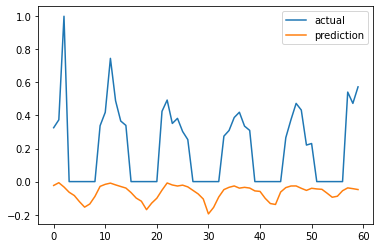

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model= Sequential()
model.add(Dense(128, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dense(64, activation="relu"))  
model.add(Dense(32, activation="relu"))  
model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


model.fit(x_train, y_train)
pred_y = model.predict(test_feature)

plt.plot(test_label.array, label = 'actual')
plt.plot(pred_y, label = 'prediction')
plt.legend()
plt.show()


# **Linear**

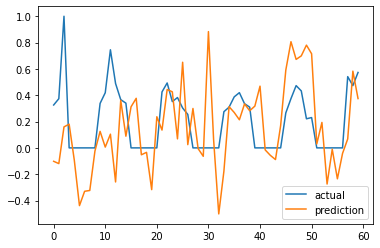

In [ ]:
from sklearn.linear_model import LinearRegression

model_linear = LinearRegression()
model_linear.fit(x_train, y_train)
linear_pred_y = model_linear.predict(test_feature)

plt.plot(test_label.array, label = 'actual')
plt.plot(linear_pred_y, label = 'prediction')
plt.legend()
plt.show()